# Boston Vaccination Research 

In [1]:
from census import Census
from us import states

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np


import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_cluster


# 1. US Census Data

In [2]:
# Replace YOUR_API_KEY with your actual API key
API_KEY = "aeca2098dcfc8374d3603b771c156c791c87be50"
census_data = Census(API_KEY)  

In [3]:
# get census data
def get_data_for_year(census, year, county_code, variables):
    """Retrieve data from Census API for a given year, state, county, and fields."""
    data = census.acs5.state_county(list(variables.keys()), states.MA.fips, county_code, year = year)
    return data

In [4]:

# 'New Bedford'-005, 'Wellesley'-021, 'Chelsea'-025, 'Revere'-025, 'Newton'-017
county_code = ['025','021','017','005']
years = [2020, 2021]

variables = {
    'B01003_001E': 'Total Population',
    'B17001_002E': 'Below Poverty Level',
    'B01001_020E': 'Population Over 65',
    'B08201_002E': 'Households with No Vehicle',
    'B15003_002E': 'No High School Diploma (25+)',
    'B19013_001E': 'Median Household Income',
    'B15003_017E': 'High School Diploma',
    'B15003_022E': 'Bachelors Degree',
    'B15003_023E': 'Masters Degree',
    'B15003_024E': 'Professional School Degree',
    'B15003_025E': 'Doctorate Degree',
    'B23025_002E': 'Labor Force',
    'B23025_004E': 'Employed',
    'B23025_005E': 'Unemployed'
}

all_data = []
for year in years:
    for code in county_code:
        data = get_data_for_year(census_data, year, code, variables)
        df = pd.DataFrame(data)
        df['year'] = year
        df['county'] = str(code)
        all_data.append(df)

census_df = pd.concat(all_data)

census_df.head()

,B01003_001E,B17001_002E,B01001_020E,B08201_002E,B15003_002E,B19013_001E,B15003_017E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B23025_002E,B23025_004E,B23025_005E,state,county,year
0,801162.0,131619.0,5696.0,99726.0,15011.0,74881.0,101671.0,146876.0,77148.0,25108.0,17061.0,476035.0,442673.0,32462.0,25,025,2020
0,703740.0,41067.0,7082.0,24887.0,5515.0,105320.0,83425.0,142423.0,86438.0,22477.0,18806.0,394476.0,376643.0,17599.0,25,021,2020
0,1605899.0,112373.0,16715.0,64294.0,15163.0,106202.0,185829.0,317752.0,221889.0,45901.0,59167.0,929011.0,888786.0,38804.0,25,017,2020
0,563301.0,58446.0,6135.0,22164.0,8132.0,71450.0,103048.0,74178.0,31709.0,5495.0,4137.0,300252.0,283747.0,16304.0,25,005,2020
0,792647.0,129207.0,6108.0,100217.0,16581.0,80260.0,99831.0,144811.0,78839.0,25222.0,17304.0,470235.0,436945.0,32537.0,25,025,2021


In [5]:
# map column names to more descriptive names
census_df = census_df.rename(columns=variables).reset_index(drop=True)
# map county codes to county names
county_codes = {
    '025': 'Suffolk',
    '021': 'Norfolk',
    '017': 'Middlesex',
    '005': 'Bristol'
}

# 'New Bedford'-005, 'Wellesley'-021, 'Chelsea'-025, 'Revere'-025, 'Newton'-017
city_codes = {
    '025': 'Chelsea & Revere',
    '021': 'Wellesley',
    '017': 'Newton',
    '005': 'New Bedford'
}

census_df['county_name'] = census_df['county'].map(county_codes)
census_df['city'] = census_df['county'].map(city_codes)
census_df


,Total Population,Below Poverty Level,Population Over 65,Households with No Vehicle,No High School Diploma (25+),Median Household Income,High School Diploma,Bachelors Degree,Masters Degree,Professional School Degree,Doctorate Degree,Labor Force,Employed,Unemployed,state,county,year,county_name,city
0,801162.0,131619.0,5696.0,99726.0,15011.0,74881.0,101671.0,146876.0,77148.0,25108.0,17061.0,476035.0,442673.0,32462.0,25,025,2020,Suffolk,Chelsea & Revere
1,703740.0,41067.0,7082.0,24887.0,5515.0,105320.0,83425.0,142423.0,86438.0,22477.0,18806.0,394476.0,376643.0,17599.0,25,021,2020,Norfolk,Wellesley
2,1605899.0,112373.0,16715.0,64294.0,15163.0,106202.0,185829.0,317752.0,221889.0,45901.0,59167.0,929011.0,888786.0,38804.0,25,017,2020,Middlesex,Newton
3,563301.0,58446.0,6135.0,22164.0,8132.0,71450.0,103048.0,74178.0,31709.0,5495.0,4137.0,300252.0,283747.0,16304.0,25,005,2020,Bristol,New Bedford
4,792647.0,129207.0,6108.0,100217.0,16581.0,80260.0,99831.0,144811.0,78839.0,25222.0,17304.0,470235.0,436945.0,32537.0,25,025,2021,Suffolk,Chelsea & Revere
5,720403.0,43922.0,7580.0,25243.0,6527.0,112089.0,82607.0,147352.0,90784.0,23360.0,20003.0,407776.0,386932.0,20588.0,25,021,2021,Norfolk,Wellesley
6,1623411.0,116510.0,17000.0,65183.0,16759.0,111790.0,184245.0,324877.0,225726.0,46713.0,62668.0,939726.0,895806.0,42519.0,25,017,2021,Middlesex,Newton
7,576070.0,61584.0,6241.0,22546.0,8725.0,74290.0,104605.0,76681.0,32343.0,5526.0,4183.0,306835.0,289204.0,17400.0,25,005,2021,Bristol,New Bedford


In [6]:

# convert to percentages
census_df['Below Poverty Level (%)'] = (census_df['Below Poverty Level'] / census_df['Total Population']) * 100
census_df['Population Over 65 (%)'] = (census_df['Population Over 65'] / census_df['Total Population']) * 100
census_df['No High School Diploma (25+) (%)'] = (census_df['No High School Diploma (25+)'] / census_df['Total Population']) * 100
census_df['Unemployed Rate (%)'] = (census_df['Unemployed'] / census_df['Labor Force']) * 100



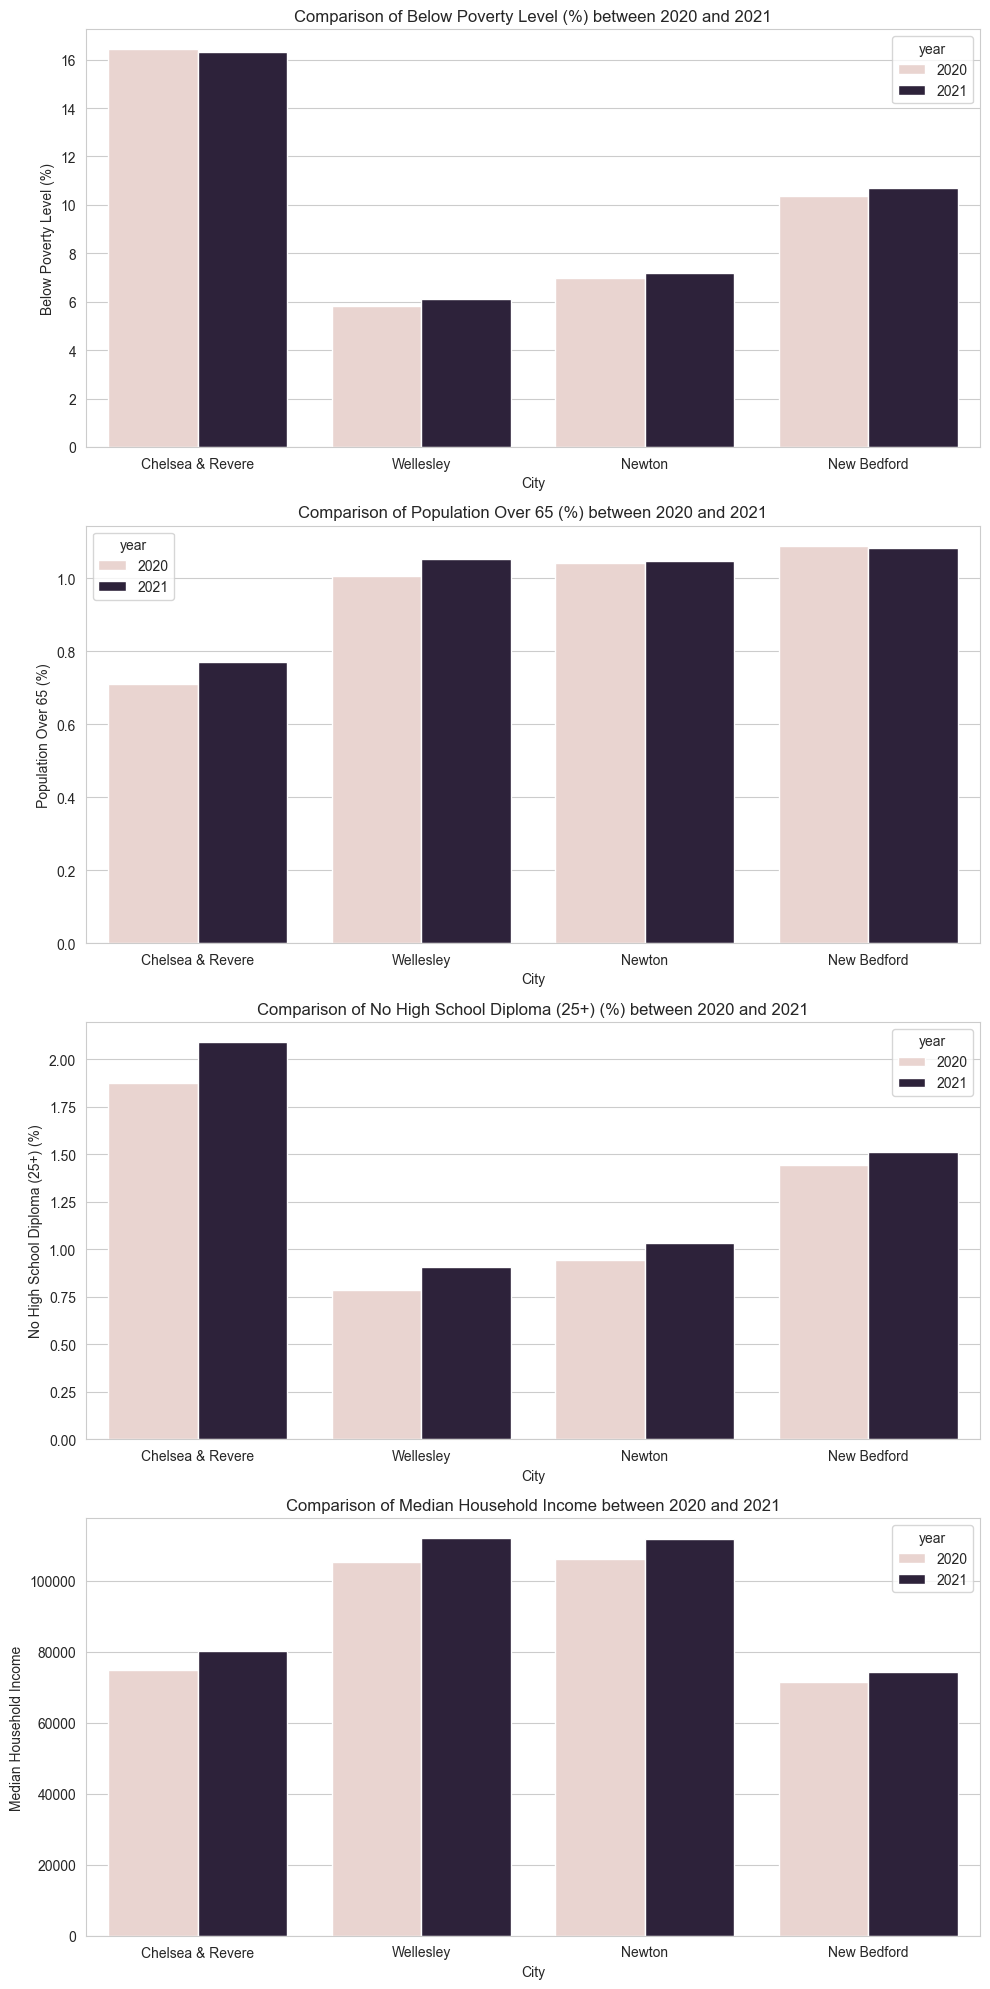

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = [
    'Below Poverty Level (%)',
    'Population Over 65 (%)',
    'No High School Diploma (25+) (%)',
    'Median Household Income'
]

# Set the style for seaborn plots
sns.set_style('whitegrid')

# Create a figure with subplots - one for each variable
fig, axes = plt.subplots(nrows=len(variables_to_plot), ncols=1, figsize=(10, 20))
# Define the colors for 2020 and 2021

# Loop through each variable to create a bar plot
for i, var in enumerate(variables_to_plot):
    sns.barplot(x='city', y=var, hue='year', data=census_df, ax=axes[i])
    axes[i].set_title(f'Comparison of {var} between 2020 and 2021')
    axes[i].set_ylabel(f'{var}')
    axes[i].set_xlabel('City')

plt.tight_layout()

# Show the plot
plt.show()


# 2. Covid_data_MA_vaccines Data
## 2.1 Import the data

In [8]:

# import the data from provided resources
# import vaccination data for race
vac_data = pd.read_excel("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/COVID-data_Massachusetts-vaccines.xlsx", sheet_name = 1)
vac_data.head()

,date,county,city,race,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated
0,2021-03-09,Barnstable,Barnstable,AI/AN,251.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-09,Barnstable,Barnstable,Asian,849.0,66.0,38.0,NaN,NaN,NaN,NaN
2,2021-03-09,Barnstable,Barnstable,Black,2610.0,249.0,151.0,NaN,NaN,NaN,98.0
3,2021-03-09,Barnstable,Barnstable,Hispanic,2644.0,232.0,120.0,NaN,NaN,NaN,112.0
4,2021-03-09,Barnstable,Barnstable,Multi,1168.0,122.0,70.0,NaN,NaN,NaN,52.0


## EDA to find data error

In [9]:
# Filtering data for Chelsea, Wellesley, Revere, Newton, New Bedford
vac_data = vac_data[vac_data['city'].isin(['New Bedford', 'Wellesley','Chelsea', 'Revere', 'Newton'])]


In [10]:
# create vac_rate

vac_data['fully_vac_rate'] = round((vac_data['fully_vaccinated'] / vac_data['population']),2) * 100
vac_data['partially_vac_rate'] = round((vac_data['partially_vaccinated'] / vac_data['population']),2) * 100
vac_data['onedose_vac_rate'] = round((vac_data['atleast_onedose'] / vac_data['population']),2) * 100
vac_data['boosted_rate'] = round((vac_data['boosted'] / vac_data['population']),2) * 100



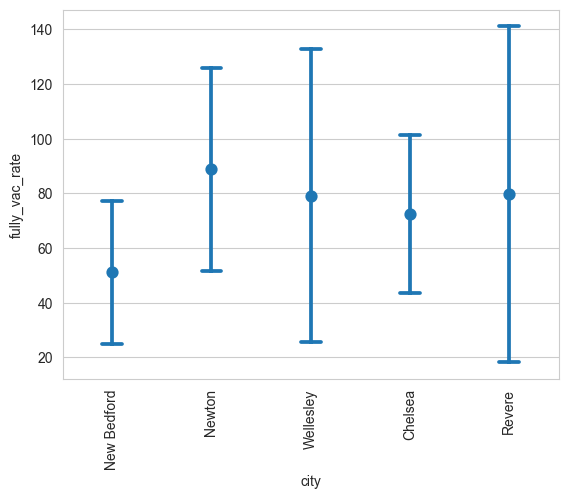

In [11]:
sns.pointplot(x = 'city', y='fully_vac_rate', data=vac_data, errorbar='sd',capsize = 0.2, linestyles = 'none')
plt.xticks(rotation = 90)
plt.show()

In [12]:
# Custom function to apply to each row
def check_vac(row):
    vaccination_columns = ["fully_vaccinated", "atleast_onedose", "boosted", "boosted_second", "partially_vaccinated"]
    for col in vaccination_columns:
        if row[col] > row["population"]:
            row[col] = np.nan
    return row

# Apply the function across the DataFrame row-wise
vac_data = vac_data.apply(check_vac, axis=1)

In [13]:
# save the data to csv
#vac_data.to_csv("/Users/zoeyy/Desktop/vac_equity/ds-bch-vaccine-equity/fa23-team/data/clean_vac_data_race.csv", index=False)

## 2.2 Data Preprocessing

In [14]:
# 0. take out the city we are interested in 

# check missing values
vac_data.isna().sum()


date                           0
county                         0
city                           0
race                           0
population                   530
atleast_onedose             1920
fully_vaccinated            1620
boosted_after_2022-09-01    4884
boosted                     2982
boosted_second              3713
partially_vaccinated        2738
fully_vac_rate              1545
partially_vac_rate          3074
onedose_vac_rate            1489
boosted_rate                2871
dtype: int64

In [15]:
# 1. missing data & replace population with max population within the same city and race.
## 1.1 create date column
vac_data['year'] = vac_data['date'].dt.year
vac_data['month'] = vac_data['date'].dt.month
vac_data['year_month'] = vac_data['date'].dt.to_period('M')

#using the max population replace the missing population
vac_data['population'] = vac_data.groupby(['year','city','race'])['population'].transform(lambda x: x.fillna(x.max()))

#using the max population replace the population
vac_data['population'] = vac_data.groupby(['year','city','race'])['population'].transform(lambda x: x.max())

print(vac_data.head(10))

           date     county         city           race  population  \
450  2021-03-09    Bristol  New Bedford          AI/AN       498.0   
451  2021-03-09    Bristol  New Bedford          Asian      1370.0   
452  2021-03-09    Bristol  New Bedford          Black      8772.0   
453  2021-03-09    Bristol  New Bedford       Hispanic     23410.0   
454  2021-03-09    Bristol  New Bedford          Multi      3891.0   
455  2021-03-09    Bristol  New Bedford          NH/PI        24.0   
456  2021-03-09    Bristol  New Bedford          White     62497.0   
457  2021-03-09    Bristol  New Bedford  Other/Unknown         NaN   
458  2021-03-09    Bristol  New Bedford          Total     99980.0   
1755 2021-03-09  Middlesex       Newton          AI/AN        64.0   

      atleast_onedose  fully_vaccinated  boosted_after_2022-09-01  boosted  \
450               NaN               NaN                       NaN      NaN   
451              80.0              36.0                       NaN      Na

In [16]:
# 2. transform data into monthly data

# Group by 'year', 'month', 'city', and 'race' and then take the max
monthly_data = vac_data.drop(columns=['date'])
monthly_data = monthly_data.groupby(['year', 'month', 'city', 'race']).max().reset_index()


monthly_data.head(10)


,year,month,city,race,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
0,2021,3,Chelsea,AI/AN,Suffolk,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
1,2021,3,Chelsea,Asian,Suffolk,810.0,374.0,201.0,NaN,NaN,NaN,173.0,25.0,21.0,46.0,NaN,2021-03
2,2021,3,Chelsea,Black,Suffolk,3336.0,608.0,372.0,NaN,NaN,NaN,236.0,11.0,7.0,18.0,NaN,2021-03
3,2021,3,Chelsea,Hispanic,Suffolk,25092.0,3357.0,1849.0,NaN,NaN,NaN,1508.0,7.0,6.0,13.0,NaN,2021-03
4,2021,3,Chelsea,Multi,Suffolk,420.0,118.0,77.0,NaN,NaN,NaN,41.0,18.0,10.0,28.0,NaN,2021-03
5,2021,3,Chelsea,NH/PI,Suffolk,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
6,2021,3,Chelsea,Other/Unknown,Suffolk,NaN,1568.0,906.0,NaN,NaN,NaN,662.0,NaN,NaN,NaN,NaN,2021-03
7,2021,3,Chelsea,Total,Suffolk,36918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03
8,2021,3,Chelsea,White,Suffolk,7307.0,3409.0,2309.0,NaN,NaN,NaN,1100.0,32.0,15.0,47.0,NaN,2021-03
9,2021,3,New Bedford,AI/AN,Bristol,498.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,2021-03


In [17]:
# 3. calculate the vaccination rate
# Calculating vaccination rate
monthly_data['fully_vac_rate'] = round((monthly_data['fully_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['partially_vac_rate'] = round((monthly_data['partially_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['onedose_vac_rate'] = round((monthly_data['atleast_onedose'] / monthly_data['population']),2) * 100
monthly_data['boosted_rate'] = round((monthly_data['boosted'] / monthly_data['population']),2) * 100

# exclude certain data points 
# exclued data of 'Other/Unknown' in race
monthly_data = monthly_data[~monthly_data['race'].isin(['Other/Unknown'])]

# exclued data of 'NH/PI' in race
monthly_data = monthly_data[~monthly_data['race'].isin(['NH/PI','Multi'])]

# exclued data of 'NH/PI' in race
monthly_data = monthly_data[~monthly_data['race'].isin(['Total'])]




In [18]:
# 4. Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

def adjust_vac_rates_for_all_columns(df, city_col, race_col, time_col, vac_rate_cols):
    """
    Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

    :return: Modified DataFrame with adjusted vaccination rates.
    """
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][race_col].unique():
            # Filter the data for the current city and race
            city_race_data = df[(df[city_col] == city) & (df[race_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_race_data.sort_values(time_col, inplace=True)
            
            # Iterate over each vaccination rate column to apply the cummax adjustment
            for vac_rate_col in vac_rate_cols:
                city_race_data[vac_rate_col] = city_race_data[vac_rate_col].cummax()
            
            # Update the original DataFrame
            df.update(city_race_data)
    
    # Return the modified DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data = adjust_vac_rates_for_all_columns(monthly_data, 'city', 'race', 'year_month', vac_columns)


In [19]:
# Fillout the missing values with previous next value
def fill_missing_with_next(df, city_col, race_col, time_col, vac_rate_cols):
    """
    Fills missing values in the vaccination rate columns with the next available non-NaN value.

    :param df: pandas DataFrame containing the data.
    :param vac_rate_cols: List of column names representing different vaccination rates.
    :return: DataFrame with missing values filled.
    """
    # Make a copy of the dataframe to avoid changing the original dataframe
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][race_col].unique():
            # Filter the data for the current city and race
            city_race_data = df[(df[city_col] == city) & (df[race_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_race_data.sort_values(time_col, inplace=True)
    
    # Iterate over each vaccination rate column and fill NaN values with the next non-NaN value
            for vac_rate_col in vac_rate_cols:
                city_race_data[vac_rate_col] = city_race_data[vac_rate_col].fillna(method='bfill')

            df.update(city_race_data)
    # Update the original DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data_filled = fill_missing_with_next(monthly_data, 'city', 'race', 'year_month', vac_columns)




/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/3085827888.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_race_data[vac_rate_col] = city_race_data[vac_rate_col].fillna(method='bfill')


In [20]:
average_vac_rate = monthly_data.groupby(['year_month', 'race'])['fully_vac_rate'].mean().reset_index()


## 2.3 EDA 

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/1529704514.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= average_vac_rate, x='year_month', y='fully_vac_rate', hue='race', ci = None, marker='o')


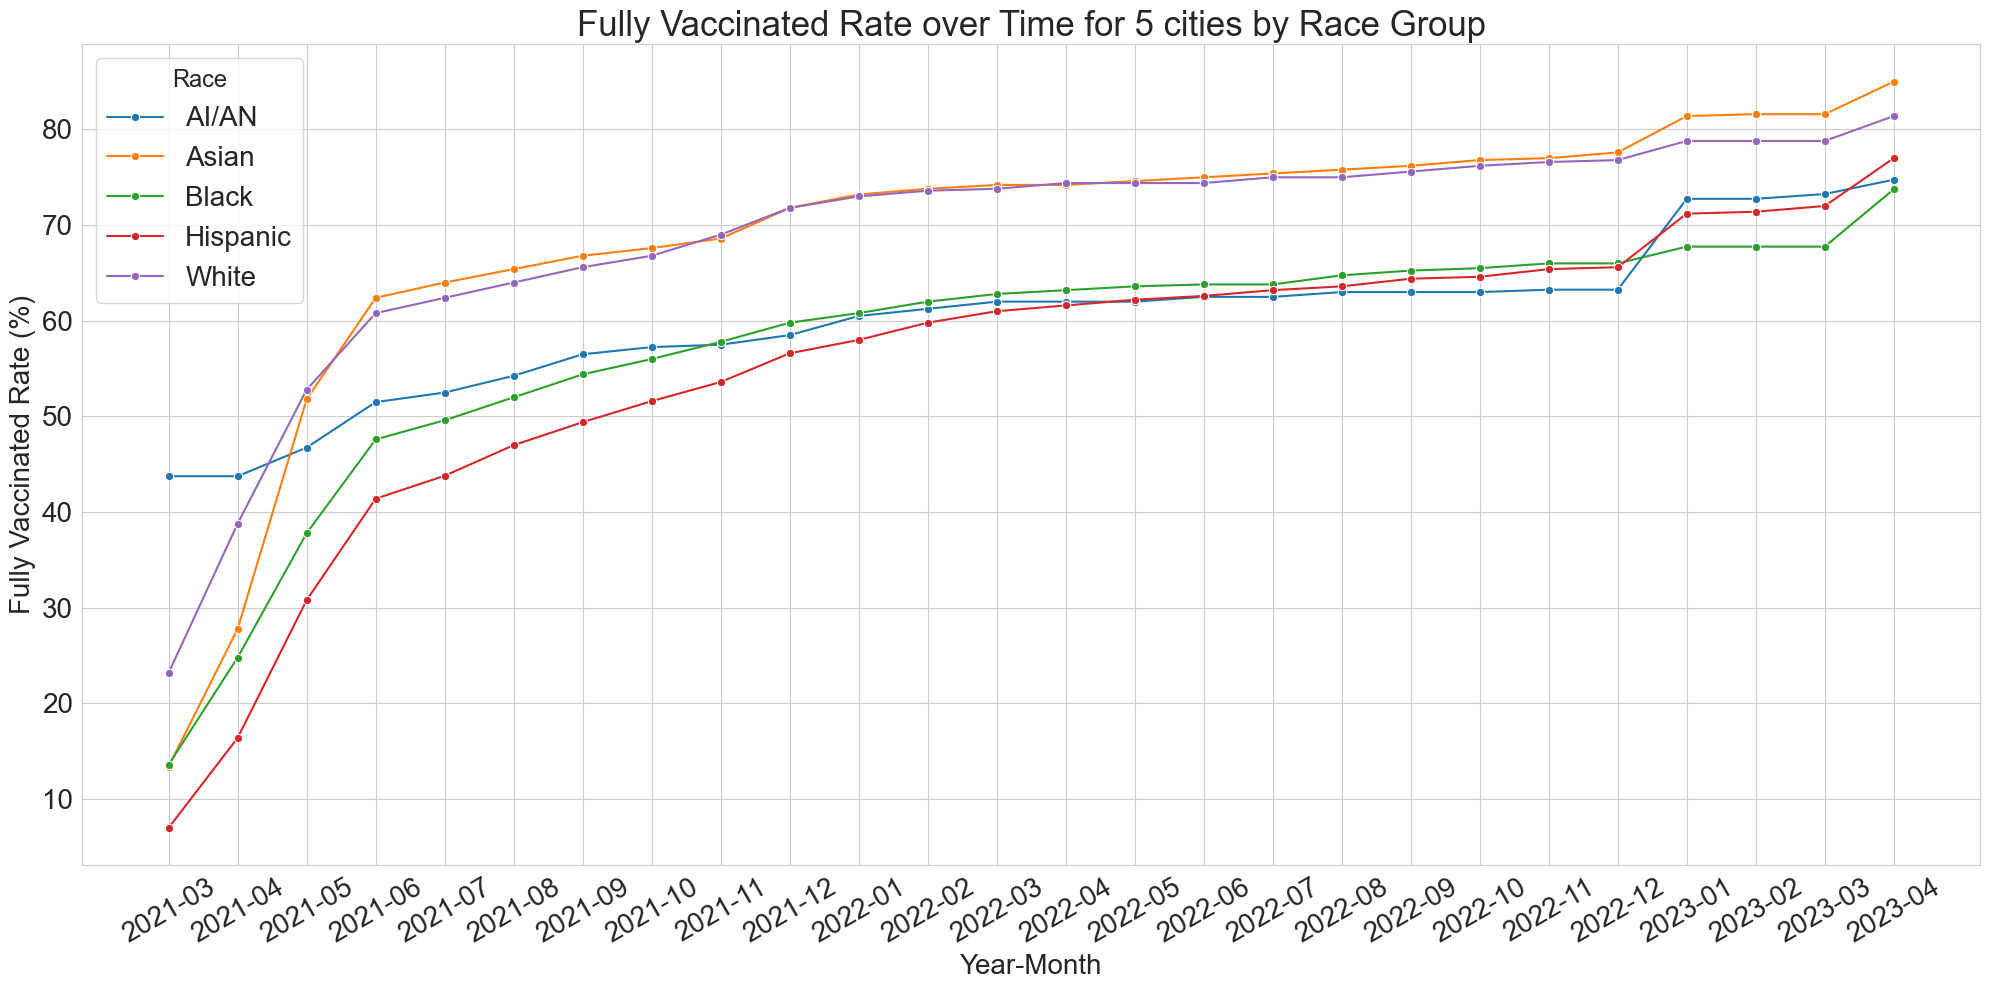

In [21]:
# Plot for all of the cities 

average_vac_rate = monthly_data_filled.groupby(['year_month', 'race'])['fully_vac_rate'].mean().reset_index()

# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
average_vac_rate['year_month'] = average_vac_rate['year_month'].astype(str)
sns.lineplot(data= average_vac_rate, x='year_month', y='fully_vac_rate', hue='race', ci = None, marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccinated Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

In [22]:
# Filter out five cities 
monthly_data = monthly_data[monthly_data['city'].isin(['New Bedford', 'Wellesley','Chelsea', 'Revere', 'Newton'])]


/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/484259880.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='race', ci = None, marker='o')


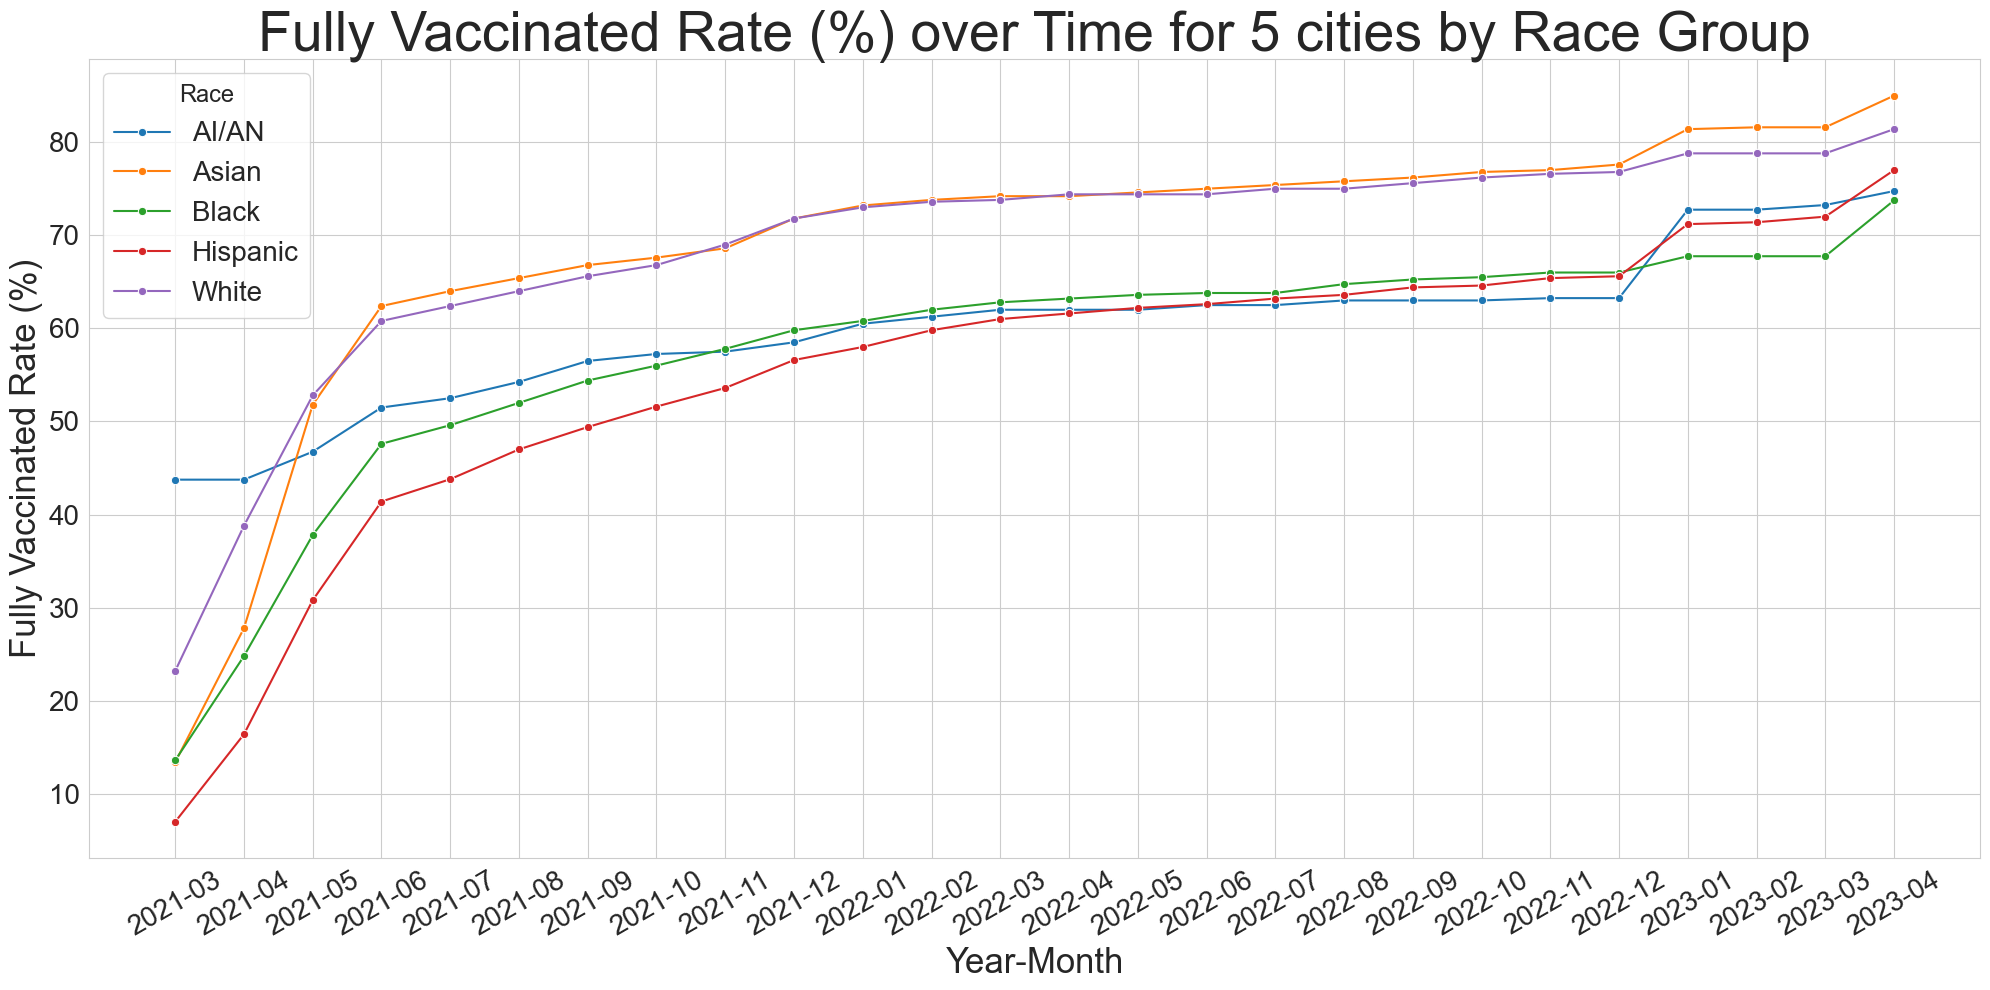

In [23]:
# Plotting fully_vac rate

plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)
sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='race', ci = None, marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccinated Rate (%) over Time for 5 cities by Race Group', fontsize = 40)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 25)
plt.xlabel('Year-Month', fontsize = 25)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/1925710293.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='partially_vac_rate', hue='race',ci = None,  marker='o')


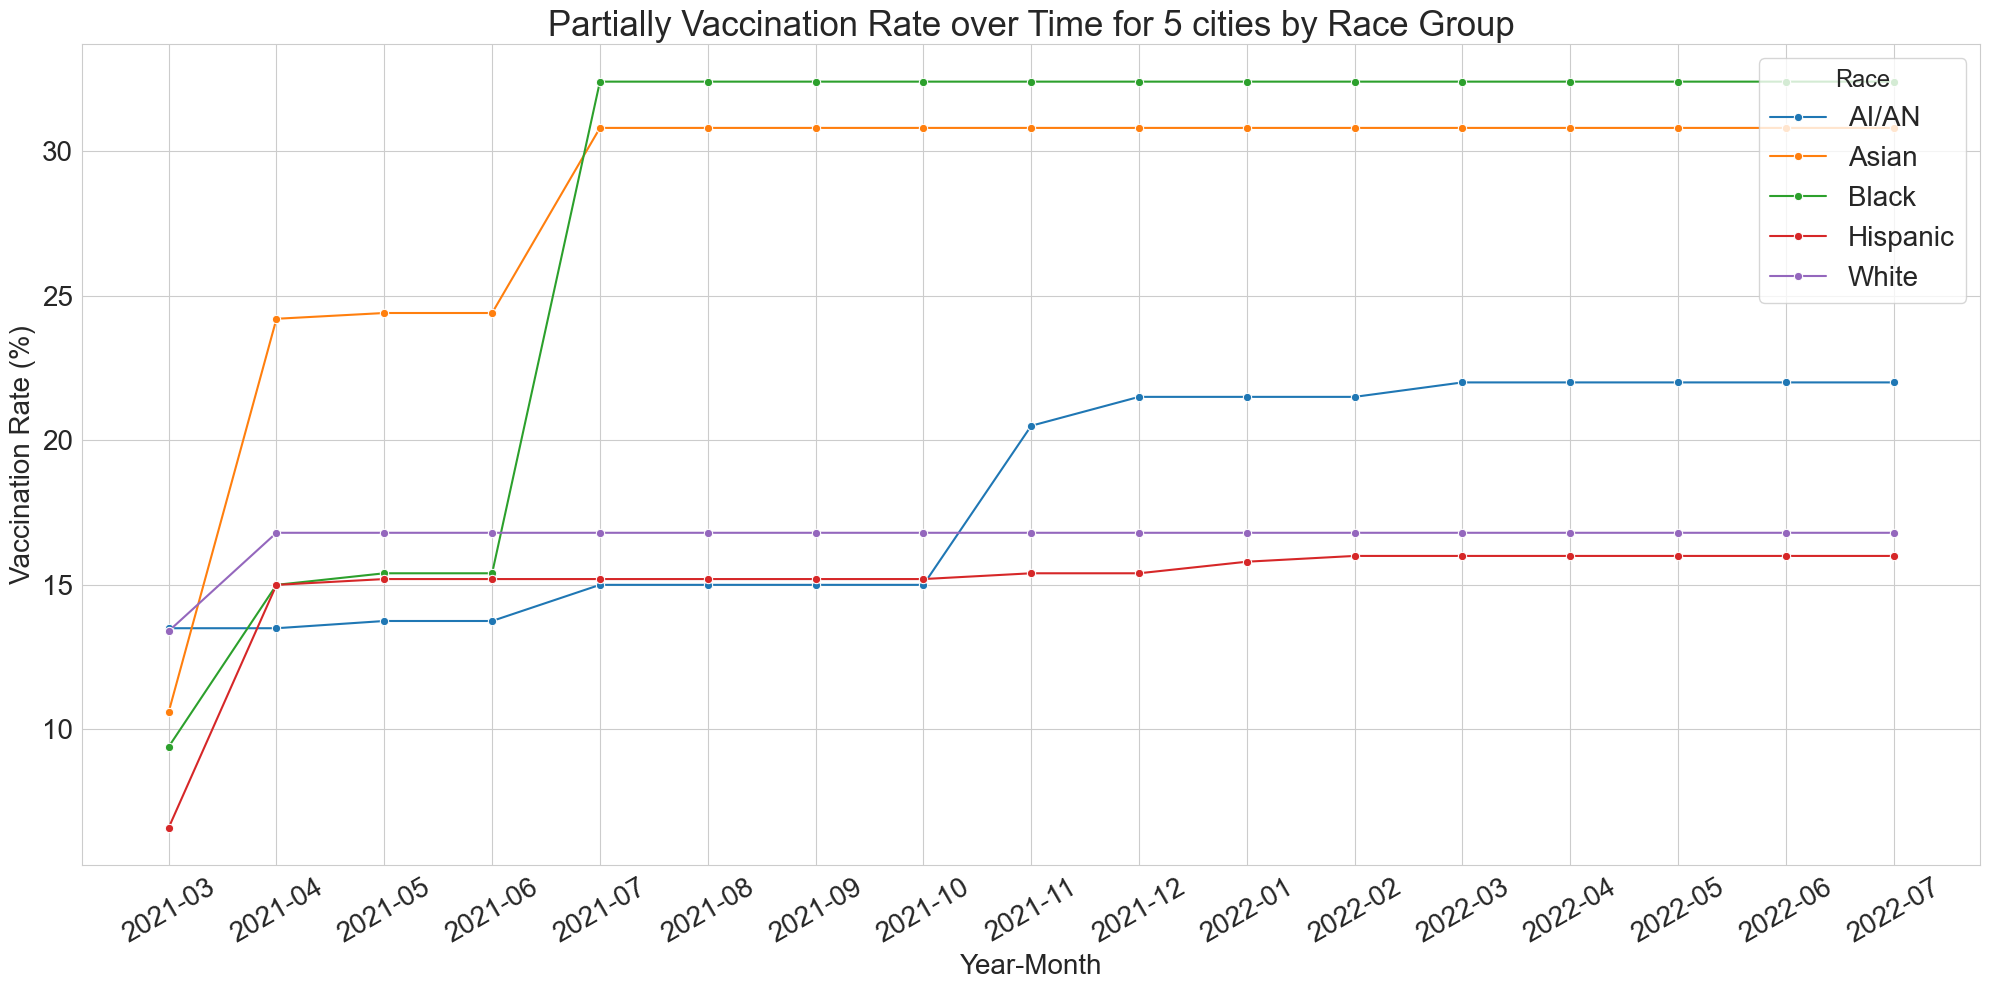

In [24]:
# Plotting partially rate

plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)
sns.lineplot(data= monthly_data_filled, x='year_month', y='partially_vac_rate', hue='race',ci = None,  marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Partially Vaccination Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper right')


plt.tight_layout()
plt.show()

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/2024669424.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='onedose_vac_rate', hue='race', ci = None, marker='o')


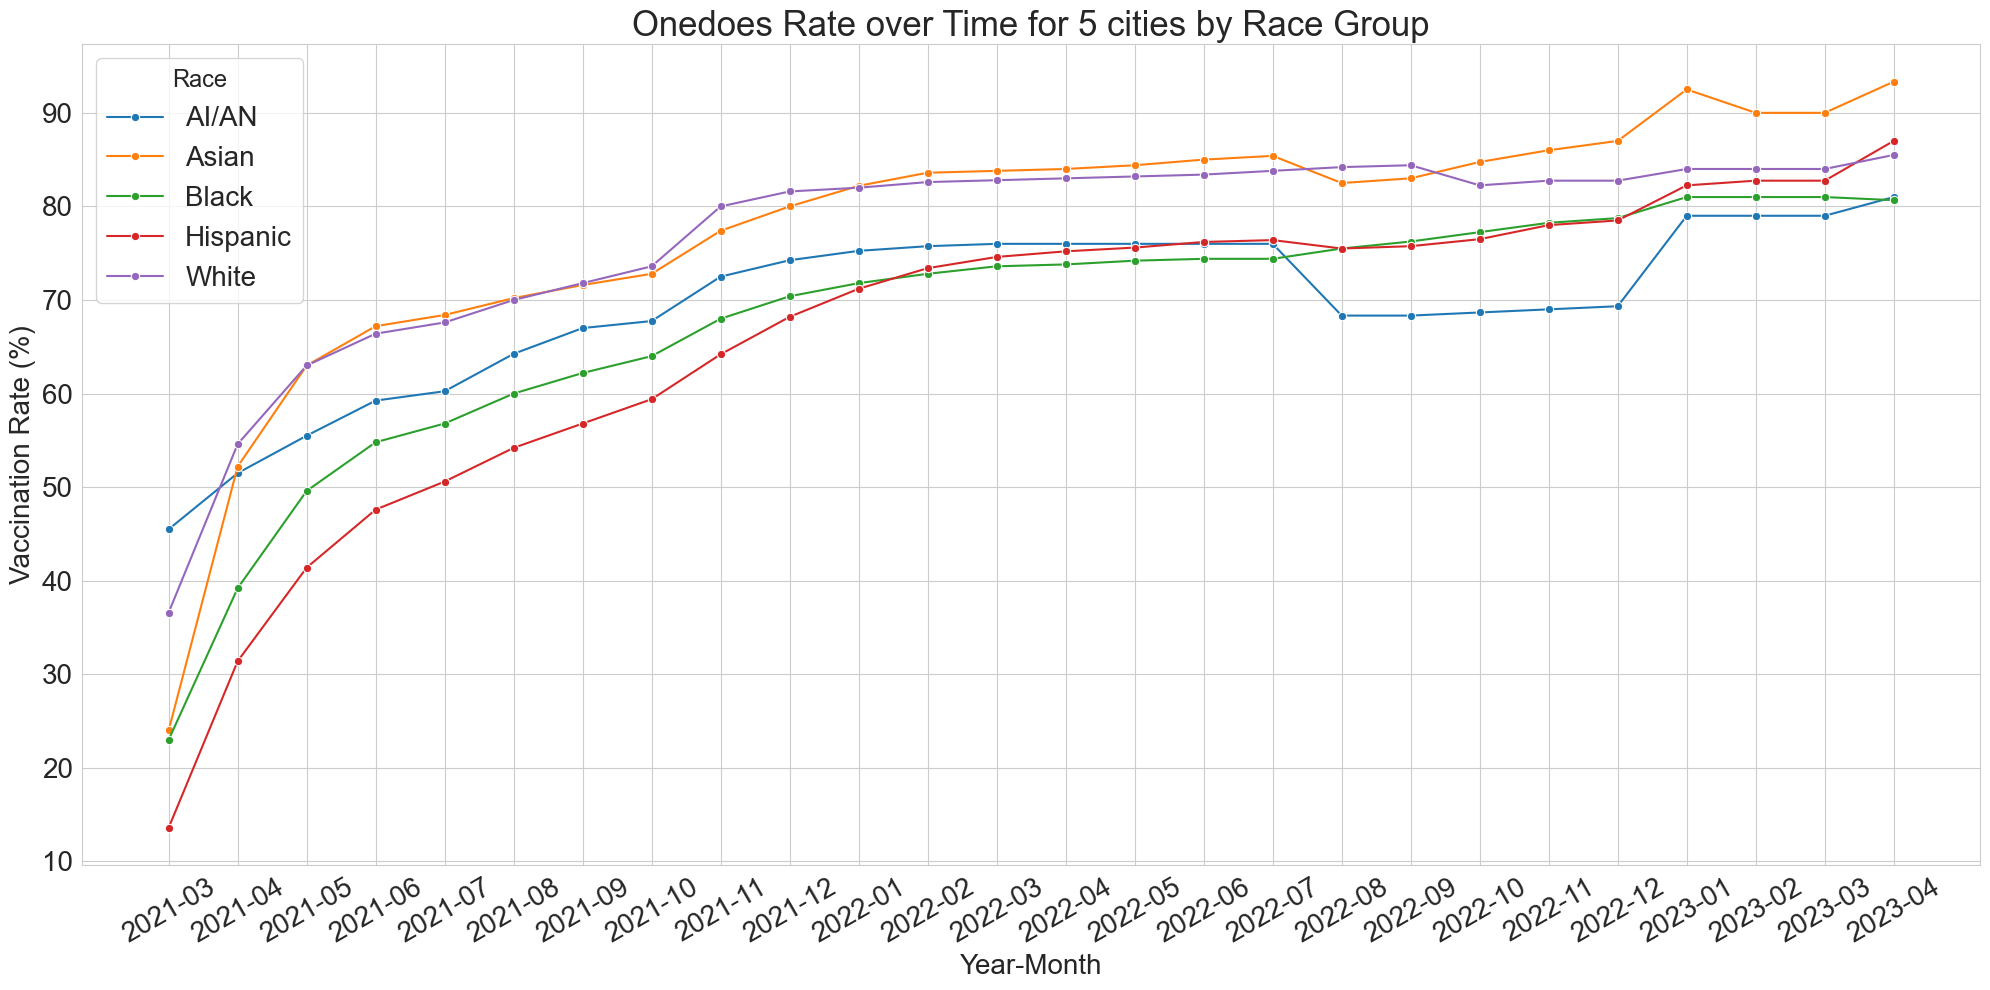

In [25]:
# Plotting onedose_vac_rate rate

plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)
sns.lineplot(data= monthly_data_filled, x='year_month', y='onedose_vac_rate', hue='race', ci = None, marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Onedoes Rate over Time for 5 cities by Race Group', fontsize = 25)
plt.ylabel('Vaccination Rate (%)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 20)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/781506487.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='boosted_rate', hue='race', ci = None, marker='o')


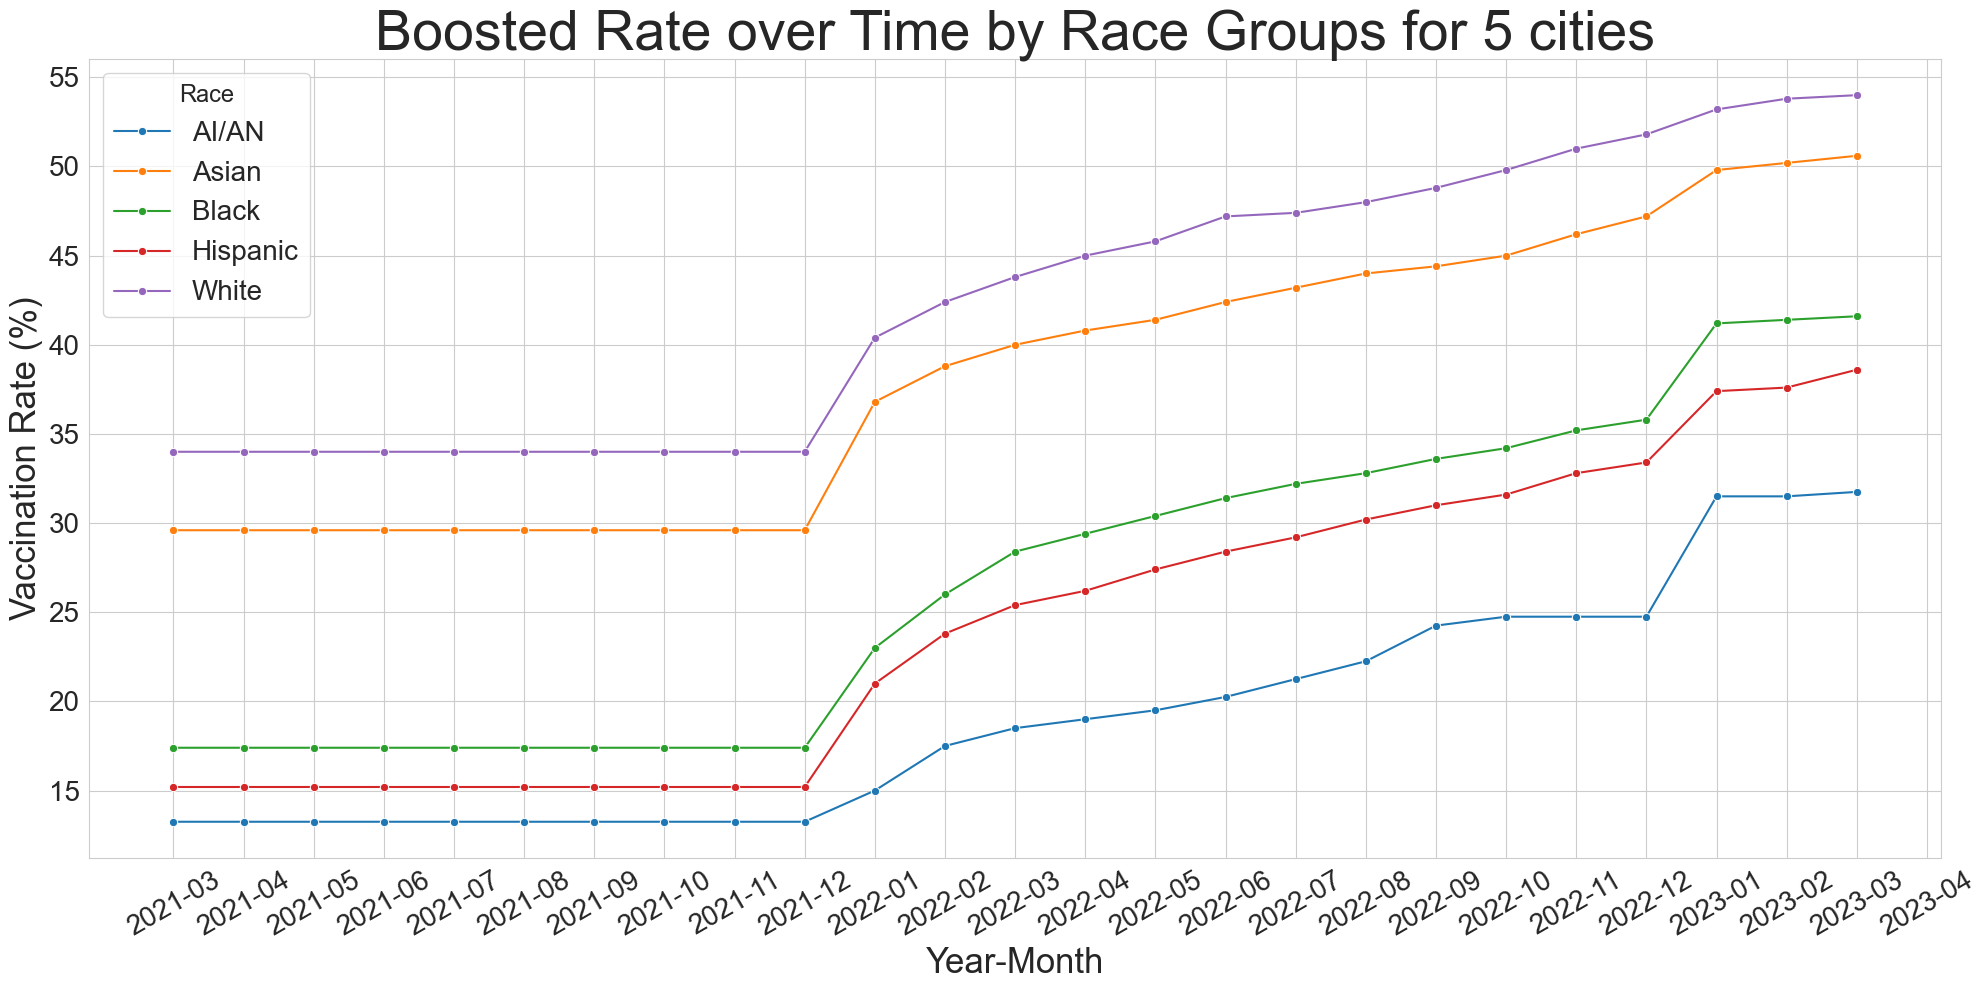

<Figure size 640x480 with 0 Axes>

In [26]:
# Plotting fully_vac rate

plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)
sns.lineplot(data= monthly_data_filled, x='year_month', y='boosted_rate', hue='race', ci = None, marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Boosted Rate over Time by Race Groups for 5 cities', fontsize = 40)
plt.ylabel('Vaccination Rate (%)', fontsize = 25)
plt.xlabel('Year-Month', fontsize = 25)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

plt.savefig('./boosted_rate_by_cities.png')

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/3155903920.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='city', ci = None, marker='o')


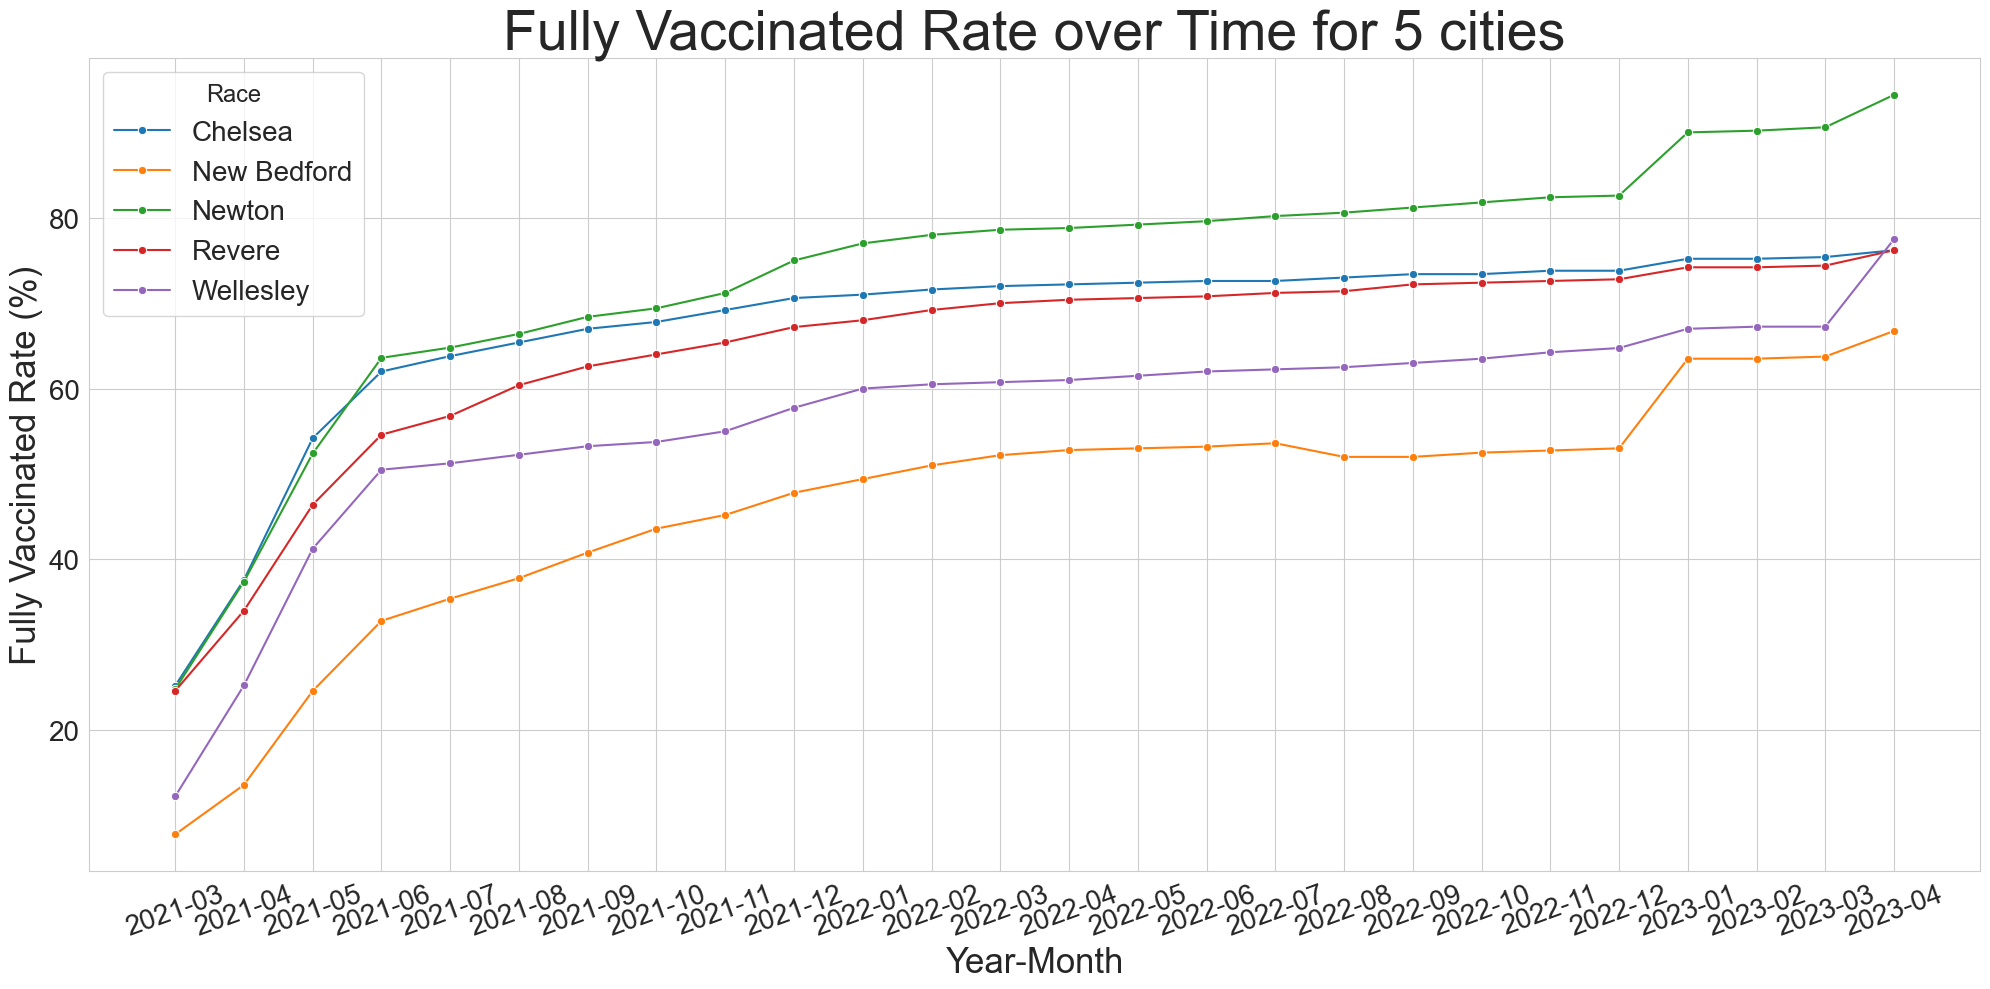

<Figure size 640x480 with 0 Axes>

In [27]:

# Define the list of cities and exotic colors
cities_to_plot = ["New Bedford", "Chelsea", "Revere", "Newton", "Wellesley"]
exotic_colors = ['#d01d20', '#ff6f18', '#FFD700', '#2fad98', '#1e52b8']

# Plotting fully_vac rate

plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)
sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='city', ci = None, marker='o')

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccinated Rate over Time for 5 cities', fontsize = 40)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 25)
plt.xlabel('Year-Month', fontsize = 25)

# adjust the tick labels and legend
plt.xticks(rotation = 20, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Race', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()
plt.show()

plt.savefig('./boosted_rate_by_cities.png')

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/3510145761.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='city', y='fully_vac_rate', data=monthly_data_svi, ax=ax2, color='red', ci = None, marker='o')
/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/3510145761.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='city', y='fully_vac_rate', data=monthly_data_svi, ax=ax2, color='red', ci = None, marker='o')
/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/3510145761.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='city', y='fully_vac_rate', data=monthly_data_svi, ax=ax2, color='red', ci = None, marker='o')
/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/3510145761.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `e

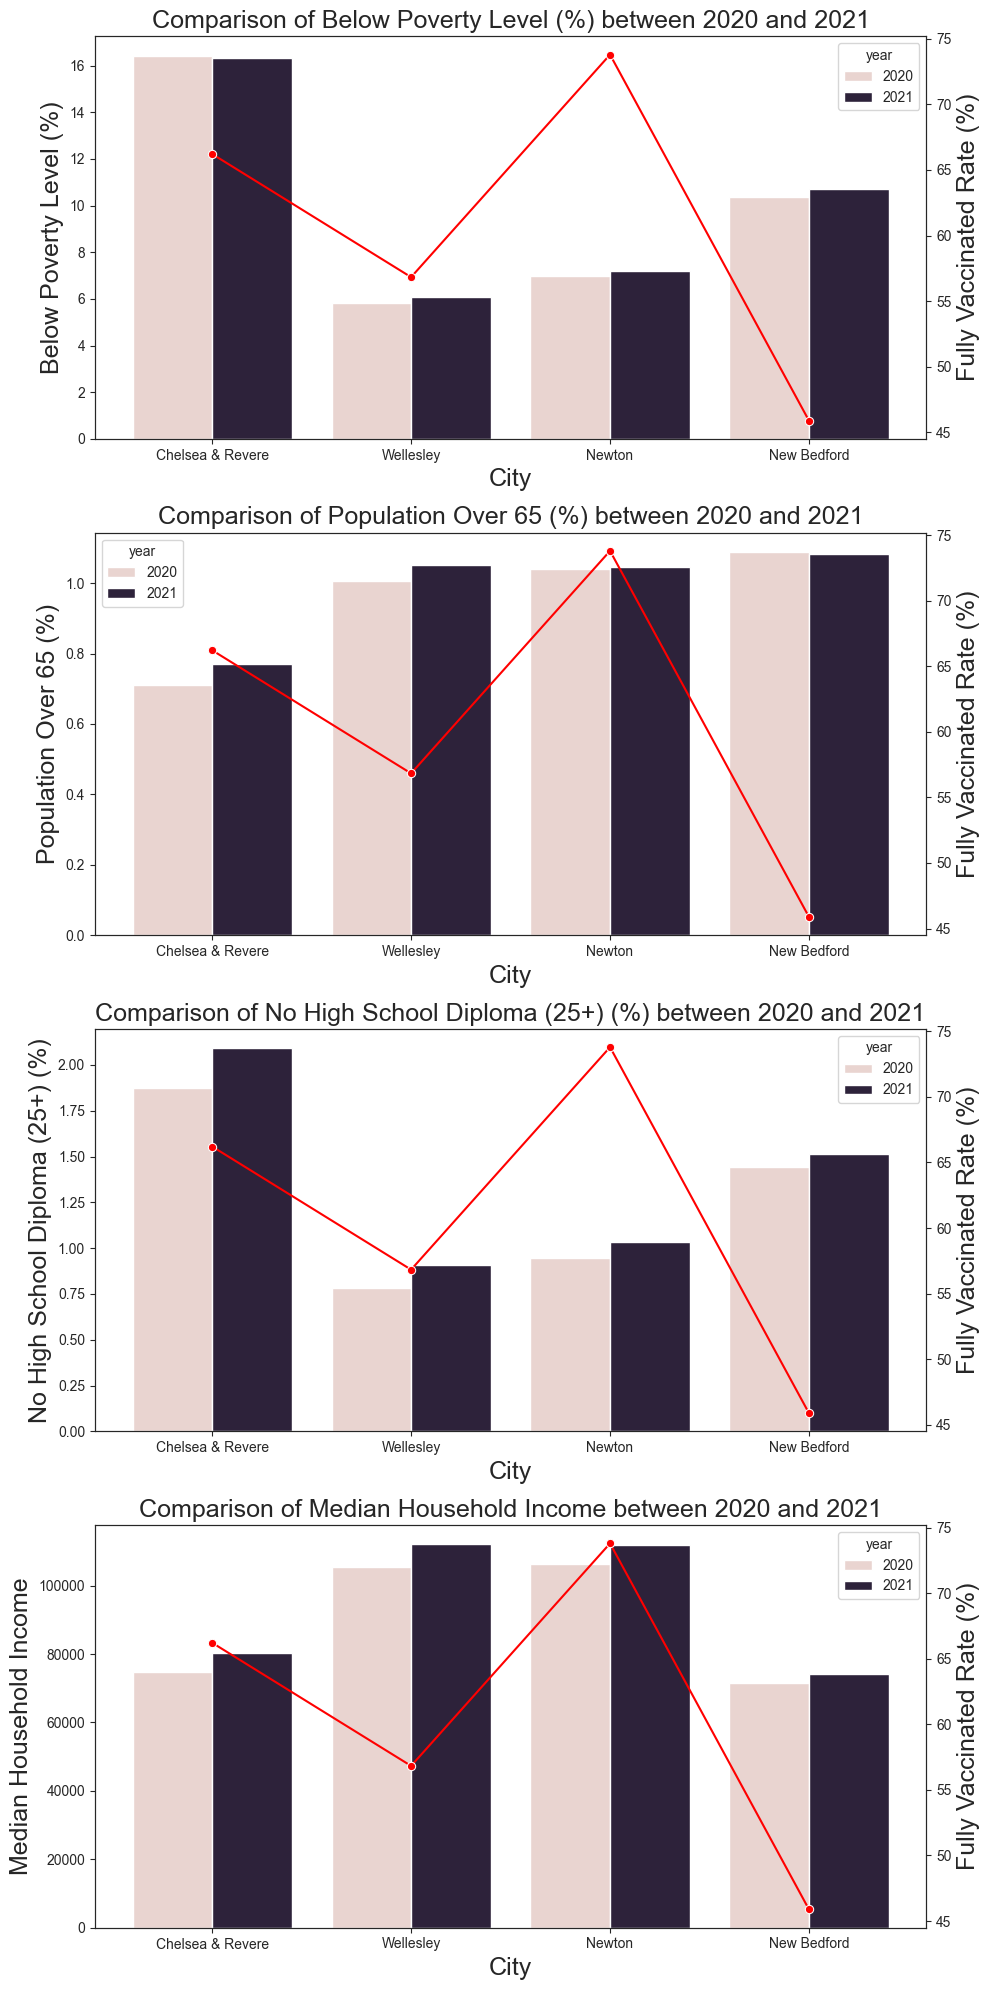

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

monthly_data_svi = monthly_data_filled
monthly_data_svi['city'] = monthly_data_svi['city'].replace({'New Bedford': 'New Bedford', 'Wellesley': 'Wellesley', 'Chelsea': 'Chelsea & Revere', 'Revere': 'Chelsea & Revere', 'Newton': 'Newton'})


variables_to_plot = [
    'Below Poverty Level (%)',
    'Population Over 65 (%)',
    'No High School Diploma (25+) (%)',
    'Median Household Income'
]

# Set the style for seaborn plots
sns.set_style('ticks')

# Create a figure with subplots - one for each variable
fig, axes = plt.subplots(nrows=len(variables_to_plot), ncols=1, figsize=(10, 20))

# Loop through each variable to create a bar plot
for i, var in enumerate(variables_to_plot):
    sns.barplot(x='city', y=var, hue='year', data=census_df, ax=axes[i])
    axes[i].set_title(f'Comparison of {var} between 2020 and 2021', fontsize = 18)
    axes[i].set_ylabel(f'{var}', fontsize = 18)
    axes[i].set_xlabel('City', fontsize = 18)

    # Add a secondary y-axis for fully vaccination rate
    ax2 = axes[i].twinx()
    sns.lineplot(x='city', y='fully_vac_rate', data=monthly_data_svi, ax=ax2, color='red', ci = None, marker='o')
    ax2.set_ylabel('Fully Vaccinated Rate (%)', fontsize = 18)

plt.tight_layout()


# Show the plot
plt.show()

#### Histogram data
#subset for two time points

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/1316869348.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


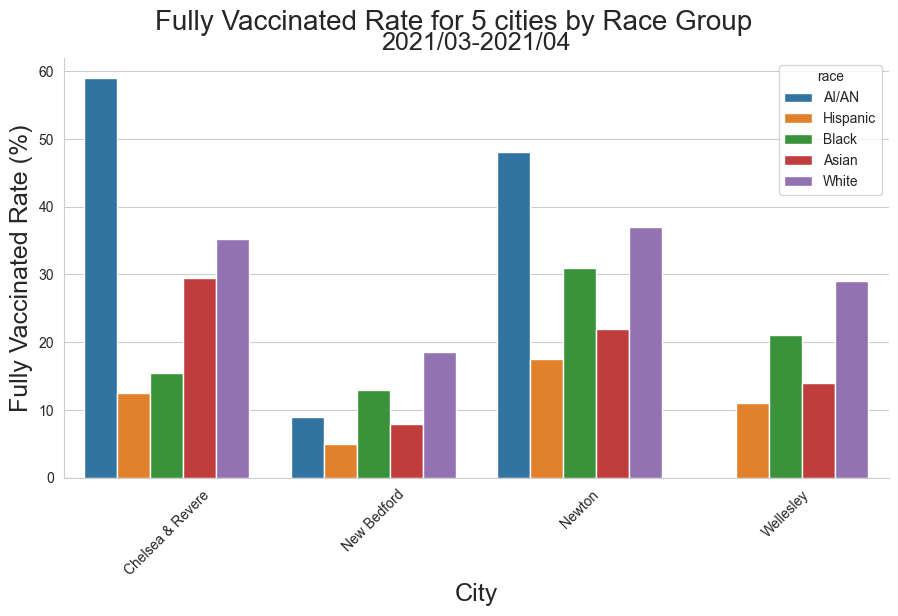

In [29]:

monthly_data_2021 = monthly_data_filled[monthly_data_filled['year_month'].isin(['2021-03','2021-04'])]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
# Define the order of the races
race_order = ["AI/AN", "Hispanic", "Black", "Asian", "White"]

# Create a bar plot with cities on the x-axis and the fully vaccination rate as the y,
# with different colors for each race.
g = sns.catplot(
    data=monthly_data_2021,
    x="city",
    y="fully_vac_rate",
    hue="race",
    hue_order=race_order,
    kind="bar",
    height=6,
    aspect=1.5,
    ci = None,
    #palette="vibrant",  # Choose a palette that makes the different races easily distinguishable
    legend_out=False
)

# Rotate the x-axis labels to make them more readable
plt.xticks(rotation=45)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 18)
plt.xlabel('City', fontsize = 18)
plt.title('2021/03-2021/04', fontsize = 18)
# Set the title of the plot
g.fig.suptitle('Fully Vaccinated Rate for 5 cities by Race Group', fontsize = 20)

# Adjust the plot to make space for the title and x-axis labels
plt.subplots_adjust(top=0.9, bottom=0.2)

# Show the plot
plt.show()



/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/2887596966.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


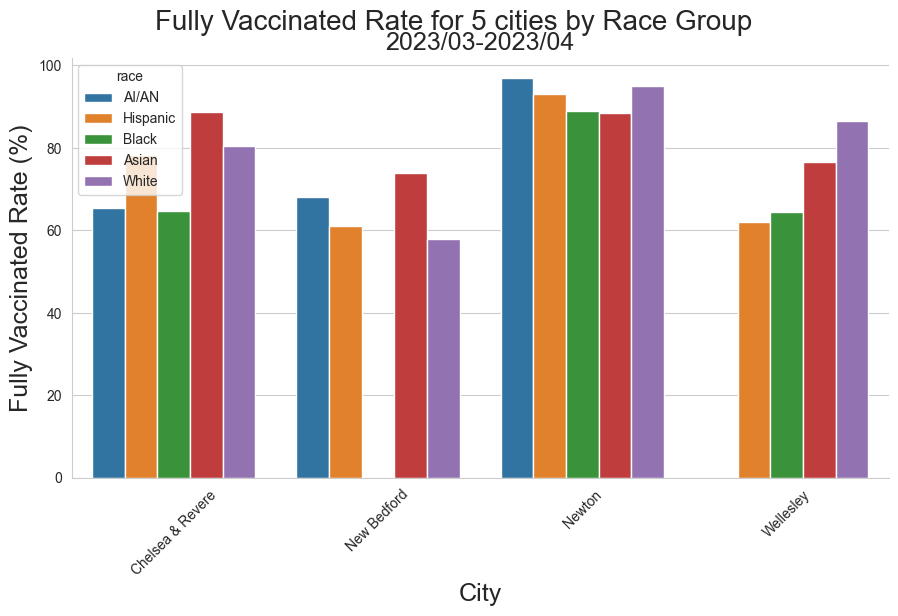

In [30]:

monthly_data_2023 = monthly_data_filled[monthly_data_filled['year_month'].isin(['2023-03','2023-04'])]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
# Define the order of the races
race_order = ["AI/AN", "Hispanic", "Black", "Asian", "White"]

# Create a bar plot with cities on the x-axis and the fully vaccination rate as the y,
# with different colors for each race.
g = sns.catplot(
    data=monthly_data_2023,
    x="city",
    y="fully_vac_rate",
    hue="race",
    hue_order=race_order,
    kind="bar",
    height=6,
    aspect=1.5,
    ci = None,
    #palette="vibrant",  # Choose a palette that makes the different races easily distinguishable
    legend_out=False
)

# Rotate the x-axis labels to make them more readable
plt.xticks(rotation=45)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 18)
plt.xlabel('City', fontsize = 18)
plt.title('2023/03-2023/04', fontsize = 18)
# Set the title of the plot
g.fig.suptitle('Fully Vaccinated Rate for 5 cities by Race Group', fontsize = 20)

# Adjust the plot to make space for the title and x-axis labels
plt.subplots_adjust(top=0.9, bottom=0.2)

# Show the plot
plt.show()

/var/folders/73/ffry5mmd1h97wrhtz73wd2v00000gn/T/ipykernel_1900/2985585070.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


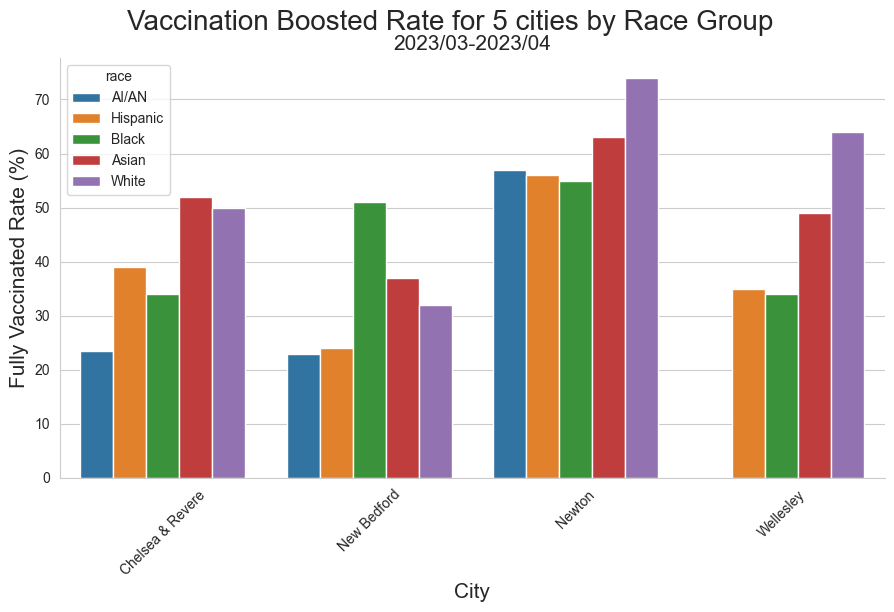

In [31]:

monthly_data_2023 = monthly_data_filled[monthly_data_filled['year_month'].isin(['2023-03','2023-04'])]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
# Define the order of the races
race_order = ["AI/AN", "Hispanic", "Black", "Asian", "White"]

# Create a bar plot with cities on the x-axis and the fully vaccination rate as the y,
# with different colors for each race.
g = sns.catplot(
    data=monthly_data_2023,
    x="city",
    y="boosted_rate",
    hue="race",
    hue_order=race_order,
    kind="bar",
    height=6,
    aspect=1.5,
    ci = None,
    #palette="vibrant",  # Choose a palette that makes the different races easily distinguishable
    legend_out=False
)

# Rotate the x-axis labels to make them more readable
plt.xticks(rotation=45)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 15)
plt.xlabel('City', fontsize = 15)
plt.title('2023/03-2023/04', fontsize = 15)
# Set the title of the plot
g.fig.suptitle('Vaccination Boosted Rate for 5 cities by Race Group', fontsize = 20)

# Adjust the plot to make space for the title and x-axis labels
plt.subplots_adjust(top=0.9, bottom=0.2)

# Show the plot
plt.show()


## 2.5 Preliminary Regression analysis

<Figure size 1000x1000 with 0 Axes>

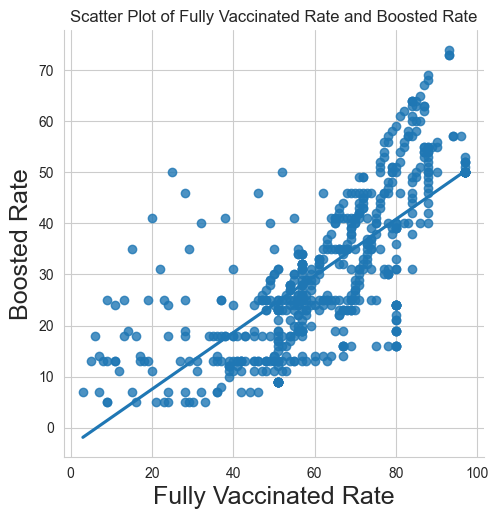

In [32]:
import seaborn as sns

plt.figure(figsize=(10, 10))
# Create a scatter plot with a line
sns.lmplot(data=monthly_data_filled, x='fully_vac_rate', y='boosted_rate', ci = None)

# Set the title and labels
plt.title('Scatter Plot of Fully Vaccinated Rate and Boosted Rate')
plt.xlabel('Fully Vaccinated Rate', fontsize = 18)
plt.ylabel('Boosted Rate', fontsize = 18)

# Show the plot
plt.show()


In [33]:
# Constructing the linear regression model
formula = 'fully_vac_rate ~ race + city'
model = smf.ols(formula, data=monthly_data_filled).fit()
# Encoding 'race' as a numerical value
#monthly_data['race_encoded'] = monthly_data['race'].astype('category').cat.codes

# Create a combined cluster variable
#monthly_data_filled['combined_cluster'] =  + "_" + 
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         fully_vac_rate   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     42.15
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.87e-48
Time:                        16:13:36   Log-Likelihood:                -2594.5
No. Observations:                 615   AIC:                             5205.
Df Residuals:                     607   BIC:                             5240.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              63.4513    